In [38]:
import pickle
import numpy as np
import osmnx as ox
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
from sort_and_filter import sort_and_filter_pol_fug_city as sort_and_filter_nodes

In [39]:
# def get_intercepted_routes(route_fugitive, tau_uv, results_positions):
#     z_r = {}
#     pi_nodes = []
#
#     for u, value in enumerate(results_positions):
#         # associated_node = labels_sorted_inv[int(u)][int(np.floor(value))]
#         pi_nodes.append(results_positions[u])
#
#     for i_r, _ in enumerate(route_fugitive):
#         z_r[i_r] = 0
#
#     for i_r, r in enumerate(route_fugitive):  # for each route
#         if any([node in pi_nodes for node in r.values()]):
#             for u, pi in enumerate(pi_nodes):  # for each police unit
#                 for time_at_node_fugitive, node_fugitive in r.items():  # for each node in the fugitive route
#                     if node_fugitive == pi:  # if the fugitive node is the same as the target node of the police unit
#                         if time_at_node_fugitive > tau_uv[u, node_fugitive]:  # and the police unit can reach that node
#                             z_r[i_r] = 1  # intercepted
#
#     return float(sum(z_r.values()))

def get_intercepted_routes(route_fugitive, results_positions):
    z_r = {}
    pi_nodes = {}

    for u, value in enumerate(results_positions):
        pi_nodes[u] = value  # results_positions[u] wordt de waarde voor sleutel u

    for i_r, _ in enumerate(route_fugitive):
        z_r[i_r] = 0

    for i_r, r in enumerate(route_fugitive):  # voor elke route
        if any(node in pi_nodes.values() for node in r.values()):  # controleer of een node in pi_nodes aanwezig is
            for u, pi in pi_nodes.items():  # voor elke politie-eenheid
                for time_at_node_fugitive, node_fugitive in r.items():  # voor elke node in de vluchtroute
                    if node_fugitive == pi:  # als de vluchtnode dezelfde is als de target node van de politie-eenheid
                        if time_at_node_fugitive > 0:  # aangenomen dat tijd altijd groter is dan 0
                            z_r[i_r] = 1  # onderschept
    return float(sum(z_r.values()))




In [40]:
def get_intercepted_routes(route_fugitive_labeled, police_start, graph, labels_full_sorted, labels_sorted_inv, results_positions):
    z_r = {}
    pi_nodes = {}

    for u, value in enumerate(results_positions):
        # associated_node = labels_sorted_inv[int(u)][int(np.floor(value))]
        associated_node = value
        travel_time_to_target = nx.shortest_path_length(graph,
                                                        source=police_start[u],
                                                        target=associated_node,
                                                        weight='police_travel_time') #of _traffic
        # associated_node = labels_full_sorted[associated_node]
        pi_nodes[u] = (associated_node, travel_time_to_target)

    for i_r, _ in enumerate(route_fugitive_labeled):
        z_r[i_r] = 0

    for i_r, r in enumerate(route_fugitive_labeled):  # for each route
        if any([node in [p[0] for p in pi_nodes.values()] for node in r.values()]):
        #if any([node in pi_nodes.values() for node in r.values()]):
            for u, pi in pi_nodes.items():  # for each police unit
                for time_at_node_fugitive, node_fugitive in r.items():  # for each node in the fugitive route
                    if node_fugitive == pi[0]:  # if the fugitive node is the same as the target node of the police unit
                        if time_at_node_fugitive > pi[1]:  # and the police unit can reach that node
                            z_r[i_r] = 1  # intercepted

    # print(sum(z_r.values())/500)

    # for r in range(len(route_fugitive_labeled)):
    #     z_r[r] = sum(sum(sum(pi_uv[u, v] * phi_rt[r, t, v] * tau_uv[u, t, v] for v in labels_full_sorted.values()) for u in range(U)) for t in range(run_length))

    return z_r

In [41]:
iteration_dicts = [{'mode': 'cool', 'jitter': 0.02, 'location':'centre', 'number_units':'2'},
                   {'mode': 'cool', 'jitter': 0.02, 'location':'centre', 'number_units':'4'},
                   {'mode': 'cool', 'jitter': 0.02, 'location':'port', 'number_units':'2'},
                   {'mode': 'cool', 'jitter': 0.02, 'location':'port', 'number_units':'4'},
                 #  {'mode': 'cool', 'jitter': 0.05},
                  # {'mode': 'hot', 'jitter': 0.05},
                  # {'mode': 'hot', 'jitter': 0.1},
                   # {'mode': 'hot', 'jitter': 0.15},
                  # {'mode': 'hot+cool', 'jitter': 0.05},  # hier niet jitter doen maar echt alles samen doen
                   ]

In [42]:
labels = ['cool, jitter=0.02, center, 2', 'cool, jitter=0.02, center, 4', 'cool, jitter=0.02, port, 2', 'cool, jitter=0.02, port, 4']  #, 'hot+cool, jitter=0.05'
#labels = ['cool, jitter=0.02', 'cool, jitter=0.05', 'hot, jitter=0.05', 'hot, jitter=0.1', 'hot, jitter=0.15', 'hot+cool'] #, 'hot+cool,jitter=0.05'

In [43]:
city = 'Rotterdam'
# mode = 'cool'
# jitter = 0.02

filepath = f"../graphs/{city}.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [ ]:
scores = np.zeros((len(iteration_dicts), len(iteration_dicts)))

for j in range(len(iteration_dicts)):
    for i in range(len(iteration_dicts)):
        mode_opt = iteration_dicts[i]['mode']
        jitter_opt = iteration_dicts[i]['jitter']
        location_opt = iteration_dicts[i]['location']
        number_units_opt = iteration_dicts[i]['number_units']
        mode_eval = iteration_dicts[j]['mode']
        jitter_eval = iteration_dicts[j]['jitter']
        location_eval = iteration_dicts[j]['location']
        number_units_eval = iteration_dicts[j]['number_units']

        # import fugitive routes
        if mode_eval == 'hot+cool':
            results_routes = []
            with open(f'../data/results_routes_hot_{city}_jitter{0.05}.pkl', 'rb') as f:
                results_routes_hot = pickle.load(f)
                results_routes += results_routes_hot
            with open(f'../data/results_routes_hot_{city}_jitter{0.1}.pkl', 'rb') as f:
                results_routes_hot = pickle.load(f)
                results_routes += results_routes_hot
            with open(f'../data/results_routes_cool_{city}_jitter{0.02}.pkl', 'rb') as f:
                results_routes_cool = pickle.load(f)
                results_routes += results_routes_cool
            with open(f'../data/results_routes_cool_{city}_jitter{0.05}.pkl', 'rb') as f:
                results_routes_cool = pickle.load(f)
                results_routes += results_routes_cool
        else:
            with open(f'../data/results_routes_{mode_eval}_{city}_jitter{jitter_eval}_{location_eval}_withtraffic.pkl', 'rb') as f:
                results_routes = pickle.load(f)

        # import police routes
        with open(f'../data/optimization/start_police_{city}_{number_units_eval}.pkl', 'rb') as f:
            police_start = pickle.load(f)
        with open(f'../data/optimization/delays_police_{city}_{number_units_eval}.pkl', 'rb') as f:
            delays = pickle.load(f)
        if mode_opt == 'hot+cool':
            with open(f'../results/optimization/results_positions_{mode_opt}_{city}_{location_opt}_{number_units_opt}.pkl', 'rb') as f:
                police_end = pickle.load(f)
        else:
            with open(f'../results/optimization/results_positions_{mode_opt}_{city}_jitter{jitter_opt}_{location_opt}_{number_units_opt}.pkl', 'rb') as f:
                police_end = pickle.load(f)

        # create tau_uv (only the part you need)
        # tau_uv = {u: ox.shortest_path_length(G, police_start[u], police_end[u]) for u, _ in enumerate(police_start)}
        #tau_uv = {(u, police_end[u]): nx.shortest_path_length(G, police_start[u], police_end[u], weight='police_travel_time') + #delays[u] for u, _ in enumerate(police_start)}

        labels_perunit_sorted, labels_perunit_inv_sorted, labels_full_sorted = sort_and_filter_nodes(G,
                                                                                             [list(route.values()) for route in results_routes][0][0],
                                                                                             results_routes,
                                                                                             police_start,
                                                                                             1800)

        # score = get_intercepted_routes(results_routes, police_end) #op 2e plaats eerst tau_uv
        score = get_intercepted_routes(results_routes, police_start, G, labels_full_sorted, labels_perunit_inv_sorted, police_end)
        if mode_eval == 'hot+cool':
            score = score/4
        # i: opt model, j: eval model
        scores[i][j] = score

        # print(mode_opt, jitter_opt, '-', mode_eval, jitter_eval)
        print(score)

In [50]:
mode_opt

'cool'

In [37]:
# scores = np.delete(scores, 5, 1)
scores

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [52]:
for i in range(len(iteration_dicts)):
    row = scores[i]
    diag = scores[i][i]
    scores[i] = (scores[i]-diag)/diag
    
# with open(f'../results/optimization/results_optimization_hot+cool_{city}_jitter{0.05}.pkl', 'rb') as f:
#     results = pickle.load(f)
# score_hot_cool = results['pct_intercepted']
# scores[5] = (scores[5]-score_hot_cool)/score_hot_cool

scores

C:\Users\Veerle\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


array([[nan]])

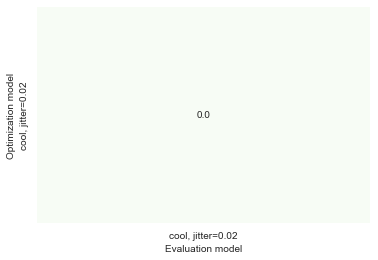

In [75]:
sns.heatmap(scores, cmap='Greens', annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, center=0, cbar=False)
plt.ylabel('Optimization model')
plt.xlabel('Evaluation model')
plt.savefig(f'heatmap_{city}.png', bbox_inches='tight', dpi=300)

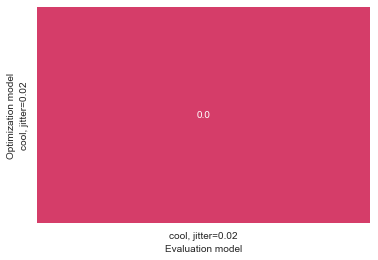

In [76]:
cmap = sns.diverging_palette(0, 255, sep=20, as_cmap=True)
sns.heatmap(scores, cmap=cmap, center=0, annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, cbar=False)
plt.ylabel('Optimization model')
plt.xlabel('Evaluation model')
plt.savefig(f'heatmap_{city}_divpalette.png', bbox_inches='tight', dpi=300)

In [77]:
# # cmap = sns.diverging_palette(0, 255, sep=8, as_cmap=True)
# sns.heatmap(scores, cmap="PRGn", center=-0.1, annot=True, fmt=".1f", xticklabels=labels, yticklabels=labels, linewidths=0.05, cbar=False)
# plt.ylabel('Optimization model')
# plt.xlabel('Evaluation model')
# plt.savefig(f'heatmap_{city}_divpalette.png', bbox_inches='tight', dpi=300)